In [175]:
from setup import *
from utils import *

In [176]:
spp = 16

# Load in scene components
materials = create_materials(with_fluids=True)
components = load_components(materials)

# Add 'bubbles' to the scene
true_bubble_positions = [
    np.array([5.0, 0.0, -12.0]),
    np.array([-8.0, 4.0, -18.0]),
]
bubble_scale = 1.0
components.update({
    # 'bubble0' : mi.load_dict({
    #     'type': 'sphere',
    #     'focused-emitter': materials['emitter'],
    #     'to_world': mi.ScalarTransform4f.translate(true_bubble_positions[0]).scale(bubble_scale),
    # }),
    'bubble1' : mi.load_dict({
        'type': 'sphere',
        'focused-emitter': materials['emitter'],
        'to_world': mi.ScalarTransform4f.translate(true_bubble_positions[1]).scale(bubble_scale),
    }),
})

# # Remove all refractive surfaces (for now)
# components.pop('viewports_outer', None)
# components.pop('viewports_inner', None)
# components.pop('outer_jar_outer_surface', None)
# components.pop('outer_jar_inner_surface', None)
# components.pop('inner_jar_outer_surface', None)
# components.pop('inner_jar_inner_surface', None)

# Generate the camera sensors
cam1 = create_sensor(sensor_number=1, sample_count=spp)
cam2 = create_sensor(sensor_number=2, sample_count=spp)
cam3 = create_sensor(sensor_number=3, sample_count=spp)

# Generate the scene to render
cam1_scene = load_scene(components=components, sensor=cam1)
cam2_scene = load_scene(components=components, sensor=cam2)
cam3_scene = load_scene(components=components, sensor=cam3)

# Compute intrinsic camera parameters
cam1_intrinsic_mat = get_ideal_camera_matrix(cam1['fov'], cam1['film']['width'], cam1['film']['height'])
cam2_intrinsic_mat = get_ideal_camera_matrix(cam2['fov'], cam2['film']['width'], cam2['film']['height'])
cam3_intrinsic_mat = get_ideal_camera_matrix(cam3['fov'], cam3['film']['width'], cam3['film']['height'])

# Extract projection matrices from sensors
c1proj = np.array(cam1['to_world'].matrix)[:3,:]
c2proj = np.array(cam2['to_world'].matrix)[:3,:]
c3proj = np.array(cam3['to_world'].matrix)[:3,:]

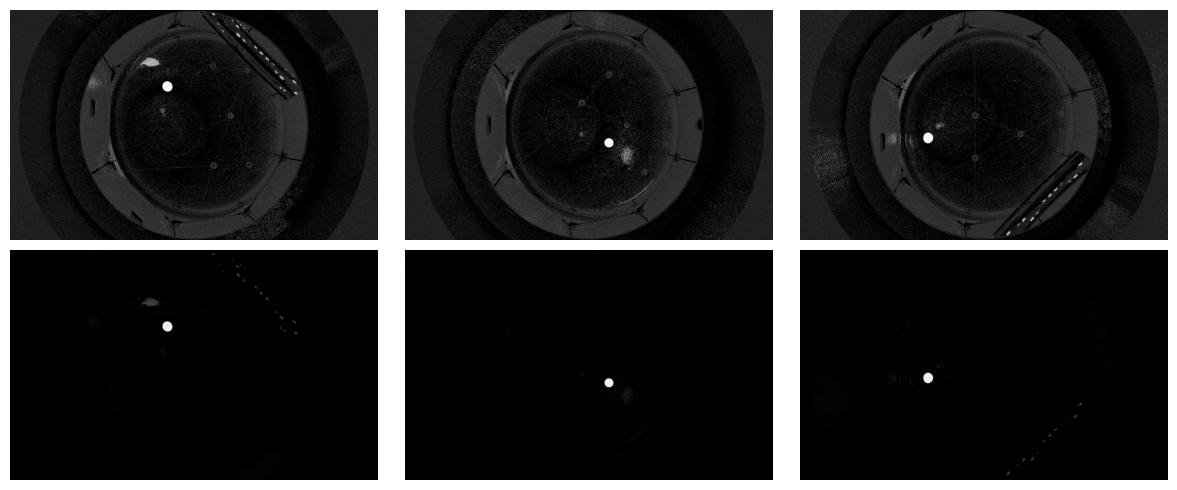

In [177]:
# Render the scenes
render1_rgb = render(cam1_scene, denoise=False) 
render2_rgb = render(cam2_scene, denoise=False)
render3_rgb = render(cam3_scene, denoise=False)

# Take only red channel
render1 = render1_rgb[:,:,0]
render2 = render2_rgb[:,:,0]
render3 = render3_rgb[:,:,0]

# Threshold the image to make 'bubble' detection easier
threshold = 0.99
threshold_render1 = np.where(render1>threshold, render1, 0).astype(np.uint8)
threshold_render2 = np.where(render2>threshold, render2, 0).astype(np.uint8)
threshold_render3 = np.where(render3>threshold, render3, 0).astype(np.uint8)

# Display the result of thresholding the renders
fig, ax = plt.subplots(2, 3, figsize=(12,5))
ax[0,0].imshow(render1**0.25, cmap='gray')
ax[0,0].axis('off')
ax[0,1].imshow(render2**0.25, cmap='gray')
ax[0,1].axis('off')
ax[0,2].imshow(render3**0.25, cmap='gray')
ax[0,2].axis('off')

ax[1,0].imshow(threshold_render1, cmap='gray')
ax[1,0].axis('off')
ax[1,1].imshow(threshold_render2, cmap='gray')
ax[1,1].axis('off')
ax[1,2].imshow(threshold_render3, cmap='gray')
ax[1,2].axis('off')
fig.tight_layout()

[[548.       266.        17.583471]]
[[709.      461.       15.65374]]
[[446.       444.        17.648104]]


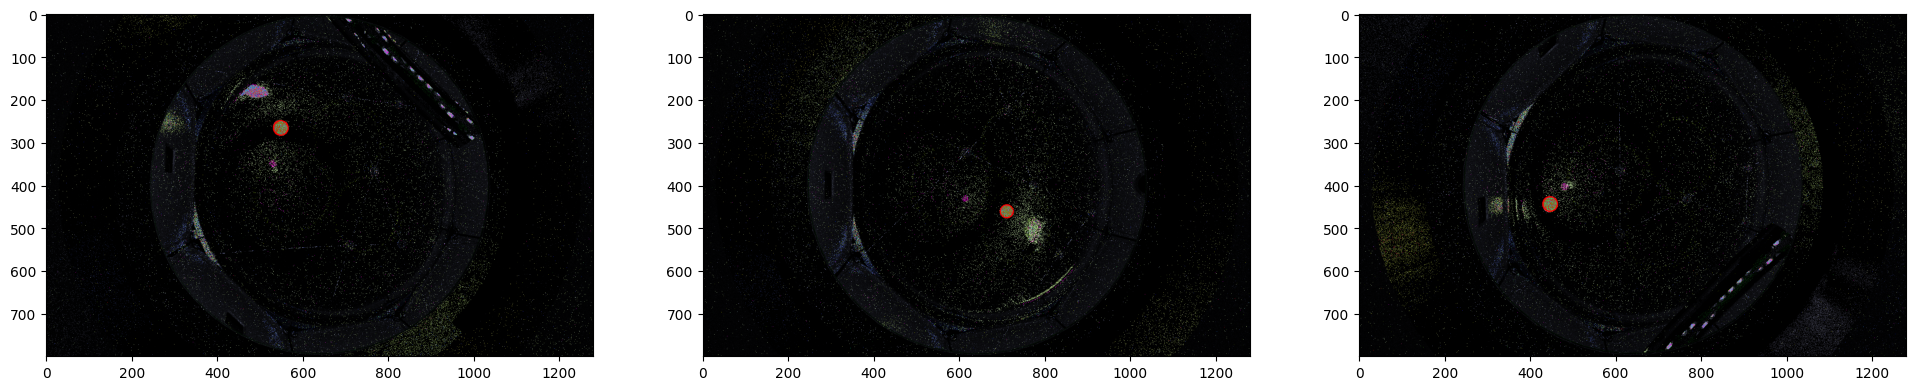

In [178]:
# Use the circle hough transform to determine the pixel locations of the bubbles
hough_params = {
    'method': cv2.HOUGH_GRADIENT_ALT,
    'dp': 0.5,
    'minDist': 10,
    'param1': 150,
    'param2': 0.9,
    'minRadius': 2,
    'maxRadius': 100
}

c1locs = cv2.HoughCircles(threshold_render1, **hough_params).reshape(-1, 3)
c2locs = cv2.HoughCircles(threshold_render2, **hough_params).reshape(-1, 3)
c3locs = cv2.HoughCircles(threshold_render3, **hough_params).reshape(-1, 3)

print(c1locs)
print(c2locs)
print(c3locs)

drawn1 = np.array(render1_rgb * 255, dtype=np.uint8)
for i in range(c1locs.shape[0]):
    drawn1 = cv2.circle(drawn1, (int(c1locs[i,0]), int(c1locs[i,1])), int(c1locs[i,2]), (0, 0, 255), 2)

drawn2 = np.array(render2_rgb * 255, dtype=np.uint8)
for i in range(c2locs.shape[0]):
    drawn2 = cv2.circle(drawn2, (int(c2locs[i,0]), int(c2locs[i,1])), int(c2locs[i,2]), (0, 0, 255), 2)

drawn3 = np.array(render3_rgb * 255, dtype=np.uint8)
for i in range(c3locs.shape[0]):
    drawn3 = cv2.circle(drawn3, (int(c3locs[i,0]), int(c3locs[i,1])), int(c3locs[i,2]), (0, 0, 255), 2)



fig, ax = plt.subplots(1, 3, figsize=(24,10))
ax[0].imshow(drawn1[:,:,::-1])
ax[1].imshow(drawn2[:,:,::-1])
ax[2].imshow(drawn3[:,:,::-1])

In [179]:
def get_xy_scale(image_width: int = 1280, image_height: int = 800, 
                 fov: float = 100, fov_axis: str = 'x') -> np.ndarray:
    """Determine the scale factor for normalized points along the x and y axes
    to account for the fov along the provided fov axis.
    
    Parameters:
        image_width: Width of the image in pixels
        image_height: Height of the image in pixels
        fov: The field of view in degrees along axis 'fov_axis'
        fov_axis: The axis along which 'fov' is defined -- either 'x', or 'y'

    Returns:
        (2,) The scale factors along the x and y axes
    """
    aspect = image_width / image_height
    xscale = 1.0
    yscale = 1.0
    if fov_axis == 'x':
        xscale = np.tan(np.deg2rad(fov) / 2.0)
        yscale = np.arctan2(xscale, aspect) * xscale
    elif fov_axis == 'y':
        yscale = np.tan(np.deg2rad(fov) / 2.0)
        xscale = np.arctan(aspect * yscale) * yscale
    else:
       print("Warning! Non-valid fov-axis provided! Defaulting to 1.0 for xy scale.")
    return np.array([xscale, yscale])


def normalize_coordinate(pixel_coord: np.ndarray, 
                         image_width: int = 1280, 
                         image_height: int = 800,
                         fov: float = 100,
                         fov_axis: str = 'x') -> np.ndarray:
    """Normalize (2,) UV pixel coordinate such that the central pixel of the 
    image is located (0, 0) and the normalized space spans [-1, 1] along U and V.
    Then, scale the normalized UV coordinates accounting for the field of view
    along the given axis. 

    Parameters:
        pixel_coord: (2,) Input pixel coordinates to be normalized
        image_width: Width of the image in pixels
        image_height: Height of the image in pixels
        fov: The field of view in degrees along axis 'fov_axis'
        fov_axis: The axis along which 'fov' is defined -- either 'x', or 'y'

    Returns:
        (2,) The normalized UV pixel coordinates
    """
    scales = get_xy_scale(image_width, image_height, fov, fov_axis)

    xn = (2.0 * pixel_coord[0] / image_width) - 1.0
    yn = (2.0 * pixel_coord[1] / image_height) - 1.0

    return np.array([xn*scales[0], yn*scales[1]])


def pixel_offset(normalized_offset: np.ndarray,
                 image_width: int = 1280,
                 image_height: int = 800,
                 fov: float = 100,
                 fov_axis: str = 'x') -> np.ndarray:
    """Take in the normalized image offset and image dimensions
    and convert the normalized offset to a pixel offset.
    
    Parameters:
        normalized_offset: (2,) Normalized UV offset
        image_width: Width of the image in pixels
        image_height: Height of the image in pixels

    Returns:
        (2,) The corresponding UV pixel offset
    """
    scales = get_xy_scale(image_width, image_height, fov, fov_axis)

    xop = normalized_offset[0] * image_width / 2.0
    yop = normalized_offset[1] * image_height / 2.0

    return np.array([xop/scales[0], yop/scales[1]])


def mid_point_two_view_triangulate(proj1: np.ndarray, proj2: np.ndarray, 
                                   p1: np.ndarray, p2: np.ndarray) -> np.ndarray:
    """Perform mid-point two-view triangulation given two projection matrices and 
    the normalized pixel coordinates of the bubbles.

    Parameters:
        proj1: (3,4) Projection matrix for the first camera
        proj2: (3,4) Projection matrix for the second camera
        p1: (2,) Normalized UV coordinate of the bubble in the first camera
        p2: (2,) Normalized UV coordinate of the bubble in the second camera

    Returns:
        (3,) World space position of estimated midpoint triangulation
    """
    # Extract the rotation matrix and translation vector from the projection matrices
    rmat1 = proj1[:,:3]
    rmat2 = proj2[:,:3]

    # Determine the out-going ray direction
    ray1d = rmat1 @ np.array([p1[0], p1[1], -1.0]).T
    ray2d = rmat2 @ np.array([p2[0], p2[1], -1.0]).T

    # The origin of the rays is the translation vectors of the projection matrices
    ray1o = proj1[:,3]
    ray2o = proj2[:,3]

    # Solve for the distance along each ray where they are closest to each other
    A = np.array([[ray1d.T @ ray1d, -ray2d.T @ ray1d],
                  [ray1d.T @ ray2d, -ray2d.T @ ray2d]])
    b = np.array([(ray2o - ray1o).T @ ray1d, (ray2o - ray1o).T @ ray2d])
    ts = np.linalg.inv(A) @ b

    # Find and return the point of bisection of the closest points of intersection
    r1t = ray1o + (ts[0] * ray1d)
    r2t = ray2o + (ts[1] * ray2d)
    return 0.5 * (r1t + r2t)


def reproject(proj: np.ndarray, loc: np.ndarray) -> np.ndarray:
    """Take in a (3,4) projection matrix and a (3,) world space location and reproject
    that world space location to normalized UV coordinates.

    Parameters:
        proj: (3,4) Projection matrix
        loc:  (3,) World space location ([x, y, z])

    Returns:
        (2,) Normalized UV coordinate of reprojected point
    """
    # Add homogeneous coordinate to world loc and multiply by projection matrix
    rep = proj @ np.concatenate([loc, [1.0]])

    # Divide by (negative) last element then truncate
    return (rep / -rep[-1])[:-1]


def reprojection_error(proj: np.ndarray, pred: np.ndarray,
                       loc: np.ndarray) -> np.ndarray:
    """Compute the difference between the normalized reprojected point 
    and normalized true point.

    Parameters:
        proj: (3,4) Projection matrix
        pred: (3,)  Predicted world coordinate ([x, y, z])
        loc:  (2,)  Actual normalized UV coordinate

    Returns:
        (2,) vector representing the difference in the normalized UV coordinates
    """
    return loc - reproject(proj, pred)


def compute_combined_reprojection_error(projs: np.ndarray, pred: np.ndarray, 
                                        locs: np.ndarray) -> float:
    """Computes the squared length of all reprojection errors which is used as our loss.
    Note: the inputs should be stacked numpy arrays such that projs[0] returns the
    projection matrix of the first camera, etc.
    
    Parameters:
        projs: (3,3,4) Stacked projection matrices of the cameras
        pred:  (3,)    Predicted world coordinate ([x, y, z])
        locs:  (3,2)   Stacked normalized UV true locations

    Returns:
        Squared length of the concatenated reprojection errors (||r||^2)
    """
    errors = []
    for i in range(projs.shape[0]):
        rep = reprojection_error(projs[i], pred, locs[i])
        errors.append(rep)

    # Note that we technically don't need to reshape since sum will just sum over all elements
    errors = np.stack(errors).reshape(1,-1)

    return np.sum(errors**2)


def average_two_view_triangulate(projs: np.ndarray, locs: np.ndarray) -> np.ndarray:
    """Perform two view mid-point triangulations for each pair of cameras and return the average
    of the predicted locations. This method is a good initial estimate for the bubble locations.

    Parameters:
        projs: (3,3,4) Stacked projection matrices of each camera
        locs:  (3,2)   Stacked normalized UV coordinate of the bubble for each camera

    Returns:
        (3,) Average of the triangulated world coordinates
    """
    # Determine the initial predicted bubble location from each pair of cameras
    c12pred = mid_point_two_view_triangulate(projs[0], projs[1], locs[0], locs[1])
    c13pred = mid_point_two_view_triangulate(projs[0], projs[2], locs[0], locs[2])
    c23pred = mid_point_two_view_triangulate(projs[1], projs[2], locs[1], locs[2])

    # Determine the average of the predicted locations (this is our initial prediction)
    return ((c12pred + c13pred + c23pred) / 3.0)


def discrete_gradient_descent_localization(projs: np.ndarray, locs: np.ndarray, 
                                           iterations: int = 100, delta: float = 0.01) -> np.ndarray:
    """Perform gradient descent to optimize the localization of a single bubble using 
    all three camera's projection matrices and the normalized UV coordinates of the 
    bubble in each of the three images.

    Parameters:
        projs: (3,3,4) Stacked projection matrices of each camera
        locs:  (3,2)   Stacked normalized UV coordinate of the bubble for each camera
        iterations: Number of optimization iterations
        delta: Step size to check in each direction for each iteration

    Returns:
        (3,) Optimized world space bubble location
        List of (3,) past predicted locations during optimization
        List of floats representing losses at each iteration of optimization
    """
    # Determine the initial prediction
    pred = average_two_view_triangulate(projs, locs)

    # Store all predicted locations (for debugging / access later)
    preds = [pred]

    # Compute inverse projection matrices
    invprojs = []
    for i in range(projs.shape[0]):
        # Convert back to 4x4
        fxf = np.concatenate([projs[i], np.array([[0.0, 0.0, 0.0, 1.0]])])
        invprojs.append(np.linalg.inv(fxf)[:3,:])
    invprojs = np.stack(invprojs)

    # Store the list of losses (for debugging / access later)
    losses = [compute_combined_reprojection_error(invprojs, pred, locs)]

    # Main optimization loop
    for i in range(iterations):

        # Test each of the 6 directions and compute their reprojection losses.
        x1 = pred + np.array([-delta, 0.0, 0.0])
        x1l = compute_combined_reprojection_error(invprojs, x1, locs)
        x2 = pred + np.array([delta, 0.0, 0.0])
        x2l = compute_combined_reprojection_error(invprojs, x2, locs)

        y1 = pred + np.array([0.0, -delta, 0.0])
        y1l = compute_combined_reprojection_error(invprojs, y1, locs)
        y2 = pred + np.array([0.0, delta, 0.0])
        y2l = compute_combined_reprojection_error(invprojs, y2, locs)

        z1 = pred + np.array([0.0, 0.0, -delta])
        z1l = compute_combined_reprojection_error(invprojs, z1, locs)
        z2 = pred + np.array([0.0, 0.0, delta])
        z2l = compute_combined_reprojection_error(invprojs, z2, locs)

        # Pick out the direction that minimizes the loss and update the predicted location.
        posns = [x1, x2, y1, y2, z1, z2]
        ls = [x1l, x2l, y1l, y2l, z1l, z2l]
        min_index = np.argmin(ls)
        pred = posns[min_index]

        preds.append(pred)
        losses.append(ls[min_index])

    return pred, preds, losses

In [180]:
c1locn = normalize_coordinate(c1locs[0,:2], fov=100, fov_axis='x')
c2locn = normalize_coordinate(c2locs[0,:2], fov=100, fov_axis='x')
c3locn = normalize_coordinate(c3locs[0,:2], fov=100, fov_axis='x')

projs = np.stack([c1proj, c2proj, c3proj], axis=0)
invprojs = []
for i in range(projs.shape[0]):
    fxf = np.concatenate([projs[i], np.array([[0.0, 0.0, 0.0, 1.0]])])
    invprojs.append(np.linalg.inv(fxf)[:3,:])
invprojs = np.stack(invprojs)
locs = np.stack([c1locn, c2locn, c3locn], axis=0)

pred, preds, losses = discrete_gradient_descent_localization(projs, locs, iterations=10000, delta=0.001)


true_loc = true_bubble_positions[1]
print("BEFORE OPTIMIZATION")
print("Initial location:            ", preds[0])
print("Difference to true location: ", preds[0] - true_loc)
print("Difference magnitude (cm):   ", np.linalg.norm(preds[0] - true_loc))
print("Pixel reprojection errors for each camera:")
print("C1: ", pixel_offset(reprojection_error(invprojs[0], preds[0], c1locn)))
print("C2: ", pixel_offset(reprojection_error(invprojs[1], preds[0], c2locn)))
print("C3: ", pixel_offset(reprojection_error(invprojs[2], preds[0], c3locn)))
print()
print("AFTER OPTIMIZATION")
print("Optimized location:          ", pred)
print("Difference to true location: ", pred - true_loc)
print("Difference magnitude (cm):   ", np.linalg.norm(pred - true_loc))
print("Pixel reprojection errors for each camera:")
print("C1: ", pixel_offset(reprojection_error(invprojs[0], pred, c1locn)))
print("C2: ", pixel_offset(reprojection_error(invprojs[1], pred, c2locn)))
print("C3: ", pixel_offset(reprojection_error(invprojs[2], pred, c3locn)))

BEFORE OPTIMIZATION
Initial location:             [ -9.98118732   5.03352606 -20.0716282 ]
Difference to true location:  [-1.98118732  1.03352606 -2.0716282 ]
Difference magnitude (cm):    3.0471171157648884
Pixel reprojection errors for each camera:
C1:  [-1.41709454 -2.72473168]
C2:  [-1.86535673  0.23309426]
C3:  [ 3.50052512 -0.13595262]

AFTER OPTIMIZATION
Optimized location:           [ -9.93618732   4.97652606 -19.9936282 ]
Difference to true location:  [-1.93618732  0.97652606 -1.9936282 ]
Difference magnitude (cm):    2.9456710420576475
Pixel reprojection errors for each camera:
C1:  [-1.51564245 -3.30766883]
C2:  [-1.86607293  0.79753142]
C3:  [ 2.31313345 -0.37950658]


In [181]:
c12pred = mid_point_two_view_triangulate(projs[0], projs[1], locs[0], locs[1])
invc1proj = np.linalg.inv(np.array(cam1['to_world'].matrix))[:3,:]
invc2proj = np.linalg.inv(np.array(cam2['to_world'].matrix))[:3,:]
invc3proj = np.linalg.inv(np.array(cam3['to_world'].matrix))[:3,:]
print("C1: ", pixel_offset(reprojection_error(invc1proj, c12pred, c1locn)))
print("C2: ", pixel_offset(reprojection_error(invc2proj, c12pred, c2locn)))

print("\nCalculating true position reprojection error (this should be small)")
print(pixel_offset(c1locn))
print(pixel_offset(reproject(invc1proj, true_loc)))
print(pixel_offset(reproject(invc1proj, true_loc)) / pixel_offset(c1locn))
print("C1: ", pixel_offset(reprojection_error(invc1proj, true_loc, c1locn)))
print("C2: ", pixel_offset(reprojection_error(invc2proj, true_loc, c2locn)))
print("C3: ", pixel_offset(reprojection_error(invc3proj, true_loc, c3locn)))

C1:  [ 0.48618818 -1.41647581]
C2:  [-0.82144121 -1.08694171]

Calculating true position reprojection error (this should be small)
[ -92. -134.]
[ -75.17927013 -110.49756209]
[0.81716598 0.82460867]
C1:  [-16.82072987 -23.50243791]
C2:  [7.16186336 9.54523943]
C3:  [-32.11904029   6.70312445]
